In [24]:
import os, sys
import torch
import numpy as np
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import time
from torch.utils.data import Dataset, DataLoader
from torchdiffeq import odeint_adjoint as odeint


from data_preprocessing import DataPreprocessing
from create_torch_datset import CustomDataset
from utils import get_batch, get_device

sys.path.append("/Users/yogeshkawadkar/Documents/sysid-neural-continuous/torchid")

from ssmodels_ct import NeuralStateSpaceModel, DeepNeuralStateSpaceModel
from ss_simulator_ct import ForwardEulerSimulator, ExplicitRKSimulator



device = get_device()
device = 'cpu'

print(f'Using device {device}')

Using device cpu


In [25]:
sampling_time_in_seconds = 0.5
# Set seed for reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Overall parameters
num_iter = 250 # 4*500-100  # gradient-based optimization steps
seq_len = 128
batch_size = 256 # batch size q
lr = 1e-3  # learning rate
test_freq = 1  # print message every test_freq iterations
test_freq_val = 10 * test_freq # do validation every test_freq_val iterations
# add_noise = True



path_dataset = "/Users/yogeshkawadkar/Desktop/data_augmentation_for_multivariate_time_series/datasets/Audi a2d2/camera_lidar/20180810_150607/bus/20180810150607_bus_signals.json"
input_signals = [
    'accelerator_pedal',
    'brake_pressure',
    'steering_angle_calculated',
    'steering_angle_calculated_sign',
    # 'pitch_angle',
    # 'roll_angle'
]

output_signals = [
    'acceleration_x',
    'acceleration_y',
    'acceleration_z',
    'angular_velocity_omega_x',
    'angular_velocity_omega_y',
    'angular_velocity_omega_z',
    'vehicle_speed',
    # 'latitude_degree',
    # 'longitude_degree',
]


In [26]:
DP = DataPreprocessing(path_dataset, input_signals, output_signals, sequence_length = 128)
DP.sampling_with_interpolation()
DP.normalize_train()

DP.train_test_split()

t_interp_train, U_train, X_train, t_interp_val, U_val,  X_val = DP.get_train_test_data()

In [27]:
t_interp_train.shape ,  t_interp_train.shape

((2629,), (2629,))

In [28]:
U_train.shape, X_train.shape

((2629, 4), (2629, 7))

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchdiffeq import odeint_adjoint as odeint

class LatentODEFunc(nn.Module):
    def __init__(self, hidden_dim):
        super(LatentODEFunc, self).__init__()
        self.hidden_dim = hidden_dim
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.Tanh(),
            nn.Linear(64, hidden_dim),
        )

    def forward(self, t, x):
        return self.net(x)

class LatentODE(nn.Module):
    def __init__(self, hidden_dim):
        super(LatentODE, self).__init__()
        self.hidden_dim = hidden_dim
        self.func = LatentODEFunc(hidden_dim)

    def forward(self, x):
        t = torch.linspace(0, 1, x.size(1))
        return odeint(self.func, x, t, method='dopri5')

class LatentODEModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LatentODEModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.latent_ode = LatentODE(hidden_dim)
        self.decoder = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        #print('input shape: {}'.format(x.shape))
        encoded = self.encoder(x)
        #print('encoded_dim : {}'.format(encoded.shape))
        latent = self.latent_ode(encoded)
        #print('latent_dim : {}'.format(latent.shape))
        decoded = self.decoder(latent)
        #print('decoded_dim : {}'.format(decoded.shape))
        return decoded

# Generate sample data
# Assume you have a dataset of shape (num_samples, sequence_length, num_features)
num_samples = 1000
sequence_length = 128
num_features = 4
#input_data = torch.randn(num_samples, sequence_length, num_features)

# Construct dependent signals
#dependent_signals = torch.randn(num_samples, sequence_length, 7)

# Concatenate independent and dependent signals
#input_data = torch.cat((input_data, dependent_signals), dim=2)

# Split into training and validation sets
#train_size = int(0.8 * num_samples)
#train_data = input_data[:train_size]
#val_data = input_data[train_size:]

# Create DataLoader
batch_size = 256
#train_loader = DataLoader(TensorDataset(train_data), batch_size=batch_size, shuffle=True)
#val_loader = DataLoader(TensorDataset(val_data), batch_size=batch_size, shuffle=False)



In [30]:
t, u , x = get_batch(X_train, U_train, t_interp_train, batch_size, seq_len, device)

In [31]:
U_val = torch.tensor(U_val.astype('float32')).to(device)
X_val = torch.tensor(X_val.astype('float32')).to(device)

In [34]:
# Define model
input_dim = num_features 
hidden_dim = 64
out_dim = 7
model = LatentODEModel(input_dim, hidden_dim, out_dim)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)



LOSS = []
VAL_LOSS = []

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    t, u , x = get_batch(X_train, U_train, t_interp_train, batch_size, seq_len, device)
    print('checkpoint')
    #u = torch.tensor(U_train.astype('float32'))
    #x = torch.tensor(X_train.astype('float32'))
    optimizer.zero_grad()
    output = model(u)[0,:,:]
    err_fit = output - x
    loss = torch.mean(err_fit**2)
    print('checkpoint2')
    loss.backward()
    print('checkpoint3')
    optimizer.step()
    print('checkpoint4')

    LOSS.append(loss.item())
    
    #break
        #train_loss += loss.item() * data.size(0)
    #train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    with torch.no_grad():
      # u = torch.tensor(U_train.astype('float32'))
       output = model(U_val)[0,:,:]

       err_fit = output - X_val
       val_loss = torch.mean(err_fit**2)
       VAL_LOSS.append(val_loss.item())
       
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.6f}, Val Loss: {val_loss.item():.6f}')

# After training, you can use the model for prediction


checkpoint
checkpoint2


KeyboardInterrupt: 

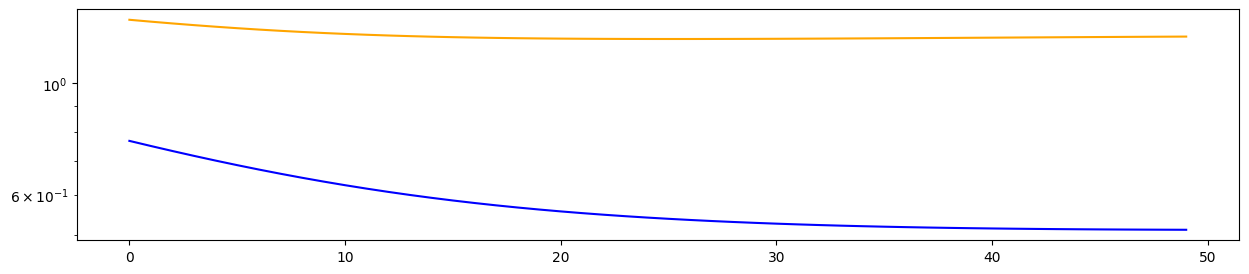

In [17]:
plt.figure(figsize=(15,3))
plt.plot(LOSS, label='loss', color='blue')
# plt.yscale('log')
# plt.figure(figsize=(15,3))
# plt.plot(VAL_LOSS, label='loss', color='orange')
plt.plot( VAL_LOSS, label='loss', color='orange')
plt.yscale('log')

# plt.plot(LOSS_CONSISTENCY, label='consistency loss')
# plt.plot(LOSS_FIT, label='fit loss')
# plt.legend()
plt.show()

In [18]:
def predict(u):
    #x0 = x[0].astype('float32')
    #x0_torch = torch.from_numpy(x0).to(device)
    #u_torch = torch.tensor(u.astype('float32')).to(device)

    with torch.no_grad():
        x_sim_torch = output = model(u)[0,:,:]
        #x_sim = x_sim_torch.squeeze(1).cpu().numpy()

    return x_sim_torch

In [ ]:
x.shape , u.shape

(torch.Size([2629, 7]), torch.Size([2629, 4]))

In [69]:
import torch
import torch.nn as nn
from torchdiffeq import odeint


class ODEFunc(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, t, x):
        return self.net(x)

class NeuralODE(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralODE, self).__init__()
        self.ode_func = ODEFunc(input_dim, hidden_dim)
        self.output_layer = nn.Linear(input_dim, output_dim)

    def forward(self, x0, t):
        out = odeint(self.ode_func, x0, t)
        #print(out.shape)

        #print(out)
        #print('---')
        return self.output_layer(out).shape

# Example usage
input_dim = 4
hidden_dim = 64
output_dim = 7
seq_len = 10

model = NeuralODE(input_dim*seq_len, hidden_dim, output_dim)

# Sample input
x0 = torch.randn(5,seq_len * input_dim)
t = torch.linspace(0, 1, seq_len)

output = model(x0, t)
print(output)

torch.Size([10, 5, 7])


In [65]:
x0

tensor([[ 1.5723,  0.5308,  0.7280,  0.2005,  0.3682, -1.0152,  0.0409,  0.0976],
        [-0.3128, -0.7258,  0.6599, -0.3286, -1.1099, -0.3897,  0.7563,  0.2068],
        [ 0.4298, -0.9723,  0.5377,  0.1554,  0.3651,  0.2270, -0.2189, -0.6674],
        [-0.6834,  0.7757, -0.3257, -0.5602,  0.0563,  0.7473,  1.2284, -1.1450],
        [ 0.7359, -0.1982, -0.3115,  0.9176, -1.0079, -0.0463, -0.0331,  0.6049]])

In [41]:
torch.linspace(0, 1, 10)

tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000])

In [ ]:
(batch_size, seq_len, num_features)